# Plotting Aviation Accident Rates Over Time
***
### T-100 Data

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
t100 = pd.read_csv('../data/t-100/t-100_departures.csv')

Note:
T-100 data for some reason has inconsistent formatting for the entries from 2000. 

 Below, I standardize the formatting so that the order of Month-year is consistent, and add a 0 before all the single-digit years (2001-2009) so that the formatting is the same. 

In [43]:
t100.loc[:11, 'Date'] = t100.loc[:11, 'Date'].apply(lambda x: '-'.join(x.split('-')[::-1]))
def pad_date_string(s):
    s = str(s)  # Ensure it's a string
    return '0' + s if len(s) < 6 else s
t100['Date'] = t100['Date'].apply(pad_date_string)
t100['Date'] = pd.to_datetime(t100['Date'],format='%y-%b').dt.strftime('%m-%Y')


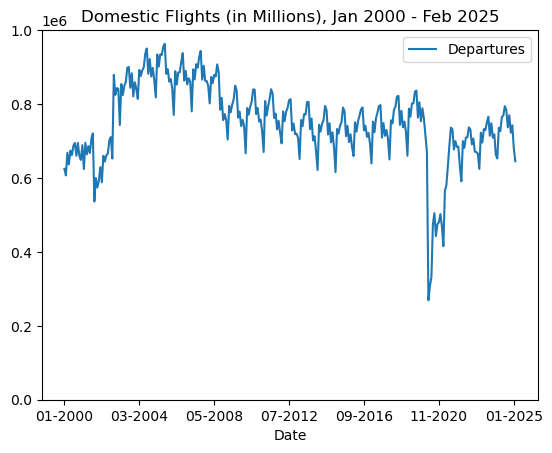

In [44]:
t100.plot('Date','Departures')
plt.title("Domestic Flights (in Millions), Jan 2000 - Feb 2025")
plt.ylim(0,1000000)
plt.show()

### Enter NTSB Data

In [45]:
ntsb = pd.read_csv('../data/ntsb-carol-00-25.csv',usecols=['EventType','EventDate','Latitude','Longitude'])
# Incident Type Dummies
onehot = pd.get_dummies(ntsb['EventType'],dtype=int)
ntsb = ntsb.join(onehot)
# Format Date to fit T-100
ntsb['Date'] = ntsb['EventDate'].str[:7]
ntsb['Date'] = pd.to_datetime(ntsb['Date'],format='%Y-%m').dt.strftime('%m-%Y')
# Aggregate by Month-Year
group = pd.DataFrame(ntsb.groupby(ntsb['Date']).agg('count'))
accidents = pd.DataFrame(group['ACC']).reset_index().rename(columns={'ACC':'accidents'})

### Joining T-100 and Aggregated NTSB Data

In [46]:
newdates = ['03-2025', '05-2025', '04-2025'] # T-100 Does not have info for these months yet
accidents = accidents[~accidents['Date'].isin(newdates)] # Remove from accident data

In [47]:
t100['Date'] = pd.to_datetime(t100['Date'], errors='coerce').dt.strftime('%m-%Y') # Re-format date
accidents['Date'] = pd.to_datetime(accidents['Date'], errors='coerce').dt.strftime('%m-%Y') # same
data = pd.merge(t100, accidents, how='left', on='Date') # Combine data

/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_82071/657732343.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/var/folders/c8/jr_n0v1x3n52_hpzs9nlqykw0000gn/T/ipykernel_82071/657732343.py:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [48]:
data['acc_rate'] = (data['accidents'] / data['Departures']) * 100 # Percentage of flights wtih accidents
data['acc_per100'] = data['accidents']/ (data['Departures']/100000) # Accidents per 100k flights

Text(0.5, 1.0, 'Accidents per 100k (All Flight Types)')

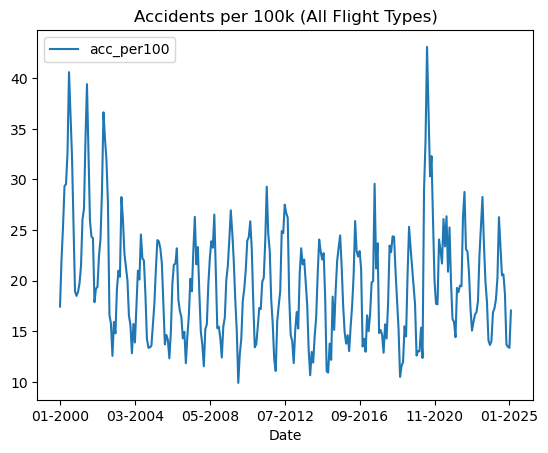

In [49]:
data.plot('Date','acc_per100')
plt.title("Accidents per 100k (All Flight Types)")

## Visualizing Accident Locations (Animated and Cumulative)

In [ ]:
import plotly.express as px
plot = ntsb[::-1]

fig = px.density_mapbox(
    plot,
    lat="Latitude",
    lon="Longitude",
    z="ACC",
    radius=2,
    animation_frame="Date",
    center=dict(lat=39, lon=-98),
    zoom=2.5,
    width=1000,
    height=750,
    title='Aviation Accident Locations Over Time (Jan 2000 - Feb 2025)',
    mapbox_style="open-street-map",
)
frame_duration = 150
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = frame_duration
fig.show()

In [63]:
fig = px.density_mapbox(
    plot,
    lat="Latitude",
    lon="Longitude",
    z="ACC",
    radius=2,
    center=dict(lat=39, lon=-98),
    zoom=2.5,
    width=1000,
    height=750,
    title='Aviation Accident Locations (Jan 2000 - Feb 2025)',
    mapbox_style="open-street-map",
)
fig.show()